## Домашняя работа №7

Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH.
Библиотеки: [Python, Tensorflow].

### Загрузка и подключение библиотек

In [1]:
%tensorflow_version 2.x

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

### Загрузка и распаковка датасета KTH

In [5]:
if 0:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

In [6]:
if 0:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

### Подготовка датасета для классификации

In [7]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [8]:
SUBSET_LEN = 180
random.shuffle(dataset)
dataset = dataset[:SUBSET_LEN]

print('Dataset samples (subset):', len(dataset))

Dataset samples (subset): 180


### Визуализация кадра из видео

videodata shape: (805, 120, 160, 3)


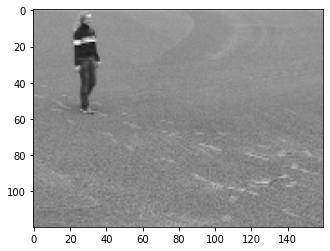

In [9]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255.
print('videodata shape:', videodata.shape)
plt.imshow(videodata[30, ...])

### Визуализация "движения"

motion shape: (804, 120, 160, 1)


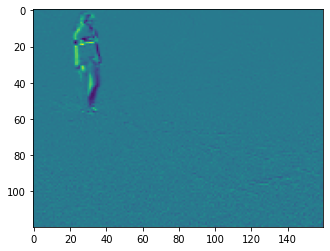

In [10]:
motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
print('motion shape:', motion.shape)
plt.imshow(motion[30, ..., 0])

### Создание модели CNN

In [11]:
def build_model():
    In = tf.keras.layers.Input(shape=(None, None, None, 1))
    Out = tf.keras.layers.Conv3D(16, (5,5,5), (1,2,2), padding='same', activation='relu')(In)
    Out = tf.keras.layers.MaxPool3D((1, 2, 2), padding='same')(Out)
    Out = tf.keras.layers.Conv3D(32, (5,5,5), (1,2,2), padding='same', activation='relu')(Out)
    Out = tf.keras.layers.MaxPool3D((1, 2, 2), padding='same')(Out)
    Out = tf.keras.layers.Conv3D(32, (3,3,3), (1,2,2), padding='same', activation='relu')(Out)
    Out = tf.keras.layers.MaxPool3D((1, 2, 2), padding='same')(Out)
    Out = tf.keras.layers.Conv3D(32, (3,3,3), (1,1,1), padding='same', activation=None)(Out)
    Out = tf.keras.layers.GlobalAveragePooling3D()(Out)
    Out = tf.keras.layers.Dense(32, activation='relu')(Out)
    Out = tf.keras.layers.Dense(6, activation=None)(Out)

    return tf.keras.Model(inputs=In, outputs=Out)

model = build_model()

In [12]:
inp = motion[None, ...]
out = model(inp)

print('Input shape:', inp.shape)
print('Output shape:', out.shape)

Input shape: (1, 804, 120, 160, 1)
Output shape: (1, 6)


### Подготовка к обучению

In [13]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/exp1')

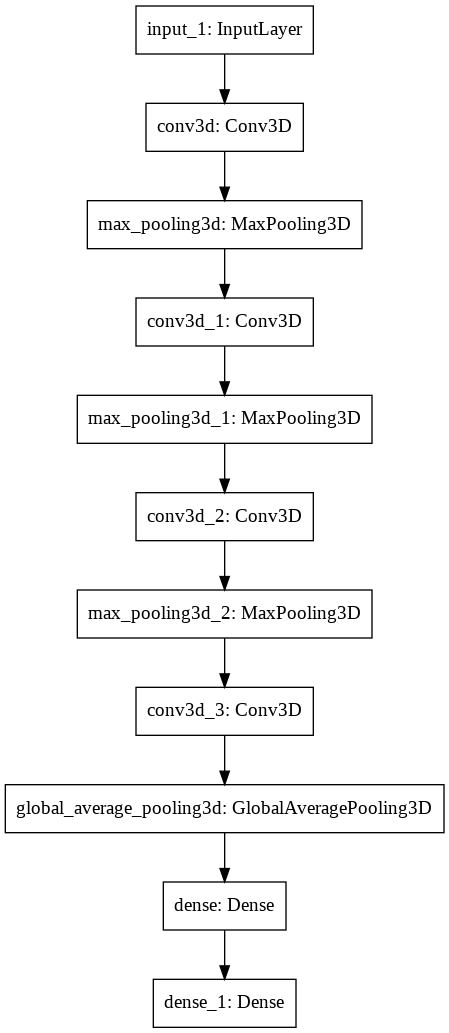

In [14]:
tf.keras.utils.plot_model(model)

### Обучение модели

In [15]:
%%time

global_step = 0
for ep in range(NUM_EPOCHS):
    for iter, (fpath, label) in enumerate(dataset):
        videodata = skvideo.io.vread(fpath)
        videodata = videodata.astype(np.float32) / 255.
        motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
        x = motion[None, ...]
        y = np.array(label)[None, ...]

        loss_value = model.train_on_batch(x, y)

        if iter % 10 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{iter}/{len(dataset)}] Loss = {loss_value}')

            with writer.as_default():
                tf.summary.scalar('loss', loss_value, global_step)

        global_step += 1

[0/10][0/180] Loss = 1.7917410135269165
[0/10][10/180] Loss = 1.477931022644043
[0/10][20/180] Loss = 1.856660008430481
[0/10][30/180] Loss = 1.7553515434265137
[0/10][40/180] Loss = 1.768470287322998
[0/10][50/180] Loss = 1.7659714221954346
[0/10][60/180] Loss = 1.7983242273330688
[0/10][70/180] Loss = 1.7796213626861572
[0/10][80/180] Loss = 1.7848862409591675
[0/10][90/180] Loss = 1.7801967859268188
[0/10][100/180] Loss = 1.8012678623199463
[0/10][110/180] Loss = 1.7558538913726807
[0/10][120/180] Loss = 1.8446472883224487
[0/10][130/180] Loss = 1.8563041687011719
[0/10][140/180] Loss = 1.714724063873291
[0/10][150/180] Loss = 1.7070873975753784
[0/10][160/180] Loss = 1.9164421558380127
[0/10][170/180] Loss = 1.9179303646087646
[1/10][0/180] Loss = 1.7236422300338745
[1/10][10/180] Loss = 1.1754498481750488
[1/10][20/180] Loss = 1.9283061027526855
[1/10][30/180] Loss = 1.5894826650619507
[1/10][40/180] Loss = 1.4354761838912964
[1/10][50/180] Loss = 1.1072421073913574
[1/10][60/180]

### Тестирование обученной модели

In [16]:
def prediction():
    fpath, cls_true = random.choice(dataset)

    videodata = skvideo.io.vread(fpath)
    videodata = videodata.astype(np.float32) / 255.
    plt.imshow(videodata[30, ...])

    motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

    out = model(motion[None, ...])[0]
    cls_pred = np.argmax(out.numpy())

    print('Истинный class:', classes[cls_true])
    print('Предсказанный class:', classes[cls_pred])

True class: walking
Predicted class: walking


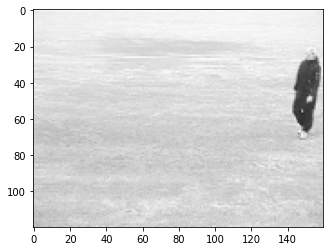

In [17]:
prediction()

True class: running
Predicted class: running


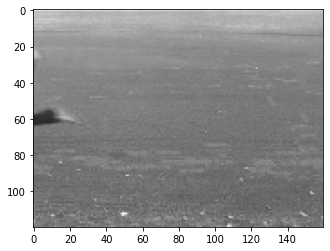

In [18]:
prediction()

True class: running
Predicted class: running


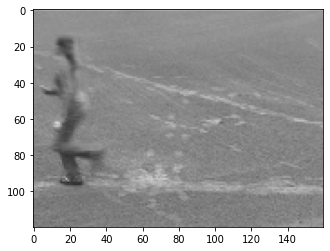

In [19]:
prediction()

True class: handwaving
Predicted class: handclapping


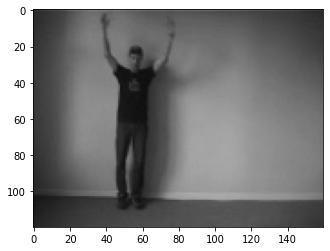

In [20]:
prediction()

True class: running
Predicted class: running


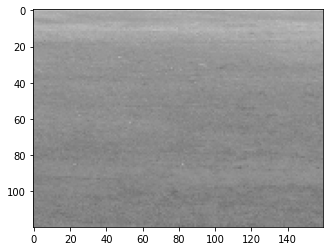

In [21]:
prediction()

True class: running
Predicted class: running


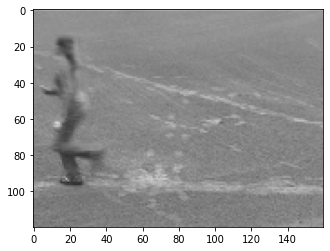

In [22]:
prediction()

True class: jogging
Predicted class: jogging


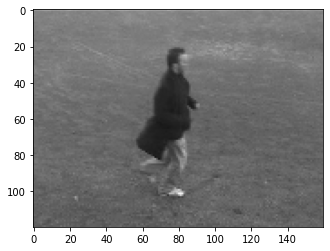

In [23]:
prediction()

True class: walking
Predicted class: walking


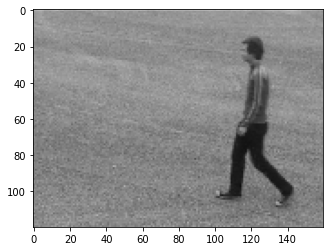

In [24]:
prediction()